# DATA 512 Human-Centered Data Science: Homework #1

## Professionalism & Reproducibility

**Goal:** The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2024. The purpose of the assignment is to develop and follow best practices for open scientific research as exemplified by code in the given repository.

### Insights from Reading
After reading the two attached documents - [Assessing Reproducibility](http://www.practicereproducibleresearch.org/core-chapters/2-assessment.html) and [The Basic Reproducible Workflow Template](https://github.com/brianckeegan/Bechdel/blob/master/Bechdel_test.ipynb), I will keep several key points in mind to maintain reproducibility in my work. First, I learnt about the importance of clear documentation that explains the data sources, processing steps, and variable calculations in detail. This transparency is vital for anyone attempting to reproduce my analysis. I also understand that using modular code with output cells will help others follow the workflow and results easily. Furthermore, I will aim to ensure that all analyses are well-documented and visualized, allowing for critical evaluation of the results. 

### License
Some portions of this code were adapted from an example created by Dr. David W. McDonald for the DATA 512 Human-Centered Data Science course, part of the University of Washington's Master of Science in Data Science program. This code is shared under the [Creative Commons CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024. Users are free to use, modify, and distribute this code under the terms of the CC-BY license, provided that appropriate credit is given to the original author. 

Data was obtained from the Wikipedia API, governed by [Wikimedia's terms of use](https://foundation.wikimedia.org/wiki/Policy:Terms_of_Use), and additional data sourced in the form of CSV file (linked in the Github Repository) by Dr. David W. McDonald and the teaching assistants for the course DATA 512.

This code is provided "as is," without any warranty of any kind. The author is not responsible for any issues that may arise from its use. Contributions to this project are welcome. Please submit a pull request or open an issue to discuss potential improvements and additions

## Data Sources and Aquisition

In order to measure article traffic from 2015-2024, I collected data from the Wikimedia Analytics API. The Pageviews API call ([documentation](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/reference/page-views.html)) provides access to desktop, mobile web, and mobile app traffic data starting from July 2015 through the previous complete month.

For this homework, we fetch details of all articles listed in the [provided CSV](https://drive.google.com/file/d/15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY/view) by calling the PageViews API with the article names. The fetched data is stored as JSON files with keys as the article title and values as the corresponding data retrieved from the API. 

I collected pageview counts for a specified subset of Wikipedia articles focused on rare diseases. This [subset](https://drive.google.com/file/d/15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY/view) was curated by matching articles from the English Wikipedia to a database maintained by the [National Organization for Rare Diseases (NORD)](https://rarediseases.org). These articles either directly discuss a rare disease or contain a section mentioning one. Using this data, I generated several related datasets, all of which will represent monthly activity over time, and we are specifically focus on pageviews initiated by actual users.

### More about Data Source
The dataset from the Wikimedia Analytics API provides access to pageview metrics for all Wikimedia projects. It includes detailed insights into how often specific pages are viewed, categorized by access types like desktop, mobile web, and mobile apps. The data spans several years, making it useful for time-series analysis on user engagement trends. This dataset allows me to gather granular statistics about user behavior, focusing on unique pageviews and filtering out bots, ensuring that I capture only legitimate human interactions across various devices.

### Importing Python Libraries

The libraries `json`, `time`, `urllib.parse`, and `os` can be imported directly.

The libraries `requests`, and `pandas` must be installed explicitly in the following way using `pip` or `pip3`.To install within a Python Notebook cell use the following command-    
`pip install <library name>`

Uncomment the cells below to install these libraries in your local python environment.

In [1]:
# These are standard python modules
import json
import time
import urllib.parse
import os

# The below libraries need to be explicitly installed

import requests
import pandas as pd

# Data Visualization libraries - need to be explicitly installed
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# !pip install requests
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn

The code uses constants to improve readability and maintainability. Certain values, such as file paths or settings, may need to be updated.

Simple descriptions of each of the constants is provided here -   
**WIKIPEDIA_ARTICLES:** Local path to the CSV file containing the Wikipedia articles.   
**API_REQUEST_PAGEVIEWS_ENDPOINT:** The REST API 'pageviews' URL - common endpoint for all 'pageviews' API requests.  
**API_REQUEST_PER_ARTICLE_PARAMS:** Parameterized string specifying the type of pageviews request ('per-article' format). Allows replacing parameters with appropriate values before making the request.  
**API_LATENCY_ASSUMED:** Assumed delay for each API request to avoid exceeding 100 requests per second.  
**API_THROTTLE_WAIT:** Throttle wait time calculation to maintain API request limits.  
**REQUEST_HEADERS:** Required headers for calling the Wikimedia API; includes a contact email for rate limiting issues.  


In [2]:
#########
#
#    CONSTANTS
#

# Local path to the CSV File containing the wikipedia articles of interest. This path is local and needs to be updated accordingly
WIKIPEDIA_ARTICLES= 'C:/Users/navya/OneDrive/Documents/HCDS/Week_1/rare-disease_cleaned.AUG.2024.csv'

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# Adding a small delay to each request to the Pageviews API, to not exceed 100 requests per second
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# Required headers for calling the Wikimedia API.
# They expect an email address for them to contact in case of issues(rate limiting, etc)
REQUEST_HEADERS = {
    'User-Agent': '<needula@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # Start date and end date as provided in 
    "end":         "2024093000"
}

# Creating templates for Mobile App and Mobile web by cloning the desktop template and updating the "access" value.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP["access"] = "mobile-app"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB["access"] = "mobile-web"

In the piece of code below, I define a time range for data collection and set up output filenames based on that range. I also make sure the required directory exists for saving the data. There's a function to fetch pageview data from the Wikipedia API for a specific article, and I handle errors and respect API rate limits while doing so. The fetched data is then saved to a JSON file using another function. Lastly, I load a list of Wikipedia articles from a CSV file and manage any errors that might come up during the file loading process.

In [3]:
# The initial and final dates are in the format YYYYMM
# These names will be used to generate filenames for storing and accessing the collected data
initial_date = "201507"
final_date = "202409"

# Generate filename for Desktop views data
desktop_file_name = f"rare-disease_monthly_desktop_{initial_date}-{final_date}.json"

# Generate filename for Mobile views data
mobile_file_name = f"rare-disease_monthly_mobile_{initial_date}-{final_date}.json"

# Generate filename for Cumulative views data
cumulative_file_name = f"rare-disease_monthly_cumulative_{initial_date}-{final_date}.json"

def ensure_directory_exists(directory_path):
    # Check to verify if the directory exists
    if not os.path.exists(directory_path):
        try:
            # Attempt to create a directory
            os.makedirs(directory_path)
        except Exception as error:
            print(f"Could not create directory: {directory_path}")
            print(error)

The API request allows me to dynamically fetch pageview data for different Wikipedia articles, making the code flexible and reusable. It ensures up-to-date information by pulling data directly from Wikipedia, and the parameterized approach allows easy adjustments for article titles or time ranges. This improves reproducibility, as other people can replicate the process by tweaking simple inputs, while built-in error handling ensures the code runs reliably.

In [10]:
#########
#
#    Functions for Data Aquisition
#

def fetch_pageviews_for_article(title=None, 
                                 api_url=API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                 api_params=API_REQUEST_PER_ARTICLE_PARAMS, 
                                 param_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP,
                                 request_headers=REQUEST_HEADERS):
    """
    Makes a REST API call to the PageViews endpoint and returns the JSON response.

    Args:
        title (str): The title of the article to request pageviews for.
        api_url (str): The URL of the API endpoint.
        api_params (str): The parameters for the API request.
        param_template (dict): The template for the request parameters.
        request_headers (dict): The headers for the API request.

    Returns:
        dict or None: The JSON response from the API call, or None if an error occurs.
    """
    
    # If a title is provided, update the request parameters
    if title:
        param_template['article'] = title

    if not param_template['article']:
        raise ValueError("An article title must be provided to make a pageviews request.")

    # URL encode the article title
    encoded_title = urllib.parse.quote(param_template['article'].replace(' ', '_'), safe='')
    param_template['article'] = encoded_title
    
    # Construct the request URL using the endpoint URL and formatted parameters
    request_url = api_url + api_params.format(**param_template)
    
    # Make the request
    try:
        # Introduce a delay to avoid exceeding request limits
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=request_headers)
        json_response = response.json()
    except Exception as error:
        print(error)
        json_response = None
    return json_response


def save_to_file(data, filepath, file_mode="a+", file_encoding='utf-8'):
    """
    Writes data to a specified file in JSON format.

    Args:
        data (any): The data to be written to the file. 
        filepath (str): The path to the file where the data will be written.
        file_mode (str, optional): The file mode in which to open the file. 
                                   Defaults to "a+" (append and read). Other modes include:
    
    Returns:
        None: This function does not return a value.
    """
    try:
        with open(filepath, file_mode, encoding=file_encoding) as f:
            json.dump(data, f, ensure_ascii=False)
    except Exception as error:
        print(error)

My goal is to produce three files:

**Monthly mobile access:** Since the API separates mobile access into two types, I'll sum these to get the total mobile pageviews. The data will be saved in a file called `rare-disease_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json`.

**Monthly desktop access:** Desktop traffic is fetched in a single request. I'll store this data in `rare-disease_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json`.

**Monthly cumulative:** This file will contain the total of both mobile and desktop traffic per article, saved as `rare-disease_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json`.

The `<startYYYYMM>` and `<endYYYYMM>` will represent the start and end year/month in the filenames. I've added print statements to track the progress of data acquisition, which takes around 50 minutes on a laptop with a 13th Gen Intel Core i5-1335U processor and 16GB of RAM.

In [5]:
# Load the list of Wikipedia articles from the CSV file into a DataFrame
article_list = pd.read_csv(WIKIPEDIA_ARTICLES)

# Sort the DataFrame by article title (disease name)
article_list = article_list.sort_values("disease").reset_index(drop=True)

# Initialize empty dictionaries to store views data
desktop_views_data = {}
mobile_views_data = {}
cumulative_views_data = {}

for idx, row in article_list.iterrows():
    # Get the article title from the DataFrame
    disease_title = row["disease"]
    print("Retrieving pageview data for disease...")
    print("Disease name:", disease_title)
    print("Index:", idx)

    # Fetch desktop views for the article
    desktop_data = request_pageviews_per_article(disease_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    desktop_items = desktop_data["items"]
    # Convert JSON to DataFrame
    desktop_views_df = pd.DataFrame(desktop_items)
    # Drop the "access" column
    desktop_views_df = desktop_views_df.drop('access', axis=1)
    # Convert the DataFrame to JSON Array and store it in the desktop views dictionary
    desktop_views_data[disease_title] = json.loads(desktop_views_df.to_json(orient="records"))
    print("Adding desktop views to dictionary...")

    # Fetch mobile views, which includes both mobile app and web views
    # Fetch Mobile App views
    mobile_app_data = request_pageviews_per_article(disease_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    mobile_app_items = mobile_app_data["items"]
    # Convert JSON to DataFrame
    mobile_app_views_df = pd.DataFrame(mobile_app_items)

    # Fetch Mobile Web views
    mobile_web_data = request_pageviews_per_article(disease_title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    mobile_web_items = mobile_web_data["items"]
    # Convert JSON to DataFrame
    mobile_web_views_df = pd.DataFrame(mobile_web_items)

    # Merge Mobile App and Mobile Web data based on shared columns
    mobile_views_combined_df = pd.merge(mobile_app_views_df, mobile_web_views_df, 
                                         on=["project", "article", "granularity", "timestamp", "agent"], 
                                         how="outer")
    # Calculate total mobile views by summing app and web views
    mobile_views_combined_df["views"] = mobile_views_combined_df["views_x"] + mobile_views_combined_df["views_y"]
    # Drop unnecessary columns
    mobile_views_combined_df = mobile_views_combined_df.drop(['access_x', 'access_y', "views_x", "views_y"], axis=1)
    # Convert to JSON Array and store it in the mobile views dictionary
    mobile_views_data[disease_title] = json.loads(mobile_views_combined_df.to_json(orient="records"))
    print("Adding mobile views to dictionary...")

    # Calculate cumulative views by merging desktop and mobile views
    cumulative_views_combined_df = pd.merge(desktop_views_df, mobile_views_combined_df, 
                                             on=["project", "article", "granularity", "timestamp", "agent"], 
                                             how="outer")
    # Sum the views for cumulative calculations
    cumulative_views_combined_df["views"] = cumulative_views_combined_df["views_x"] + cumulative_views_combined_df["views_y"]
    # Drop unnecessary view columns
    cumulative_views_combined_df = cumulative_views_combined_df.drop(["views_x", "views_y"], axis=1)
    # Convert to JSON Array and store it in the cumulative views dictionary
    cumulative_views_data[disease_title] = json.loads(cumulative_views_combined_df.to_json(orient="records"))
    print("Adding cumulative views to dictionary...")

    print("--------")
    print()


Retrieving pageview data for disease... 
Disease name: 18p
Index:  0
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: 18p-
Index:  1
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: 2006 in Africa
Index:  2
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: 2007 in Africa
Index:  3
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: 2009 swine flu pandemic vaccine
Index:  4
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views t

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Acute intermittent porphyria
Index:  40
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Acute myeloid leukemia
Index:  41
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Acute promyelocytic leukemia
Index:  42
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Acute respiratory distress syndrome
Index:  43
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Alpha-thalassemia
Index:  79
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Alport syndrome
Index:  80
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Alström syndrome
Index:  81
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Alternating hemiplegia of childhood
Index:  82
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Argininemia
Index:  118
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Argininosuccinate synthase
Index:  119
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Argininosuccinic aciduria
Index:  120
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Aromatic L-amino acid decarboxylase deficiency
Index:  121
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...


Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Avita Medical
Index:  156
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Axitinib
Index:  157
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: B virus
Index:  158
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Babesiosis
Index:  159
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Balan

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Blastoma
Index:  195
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Blastomycosis
Index:  196
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Blepharophimosis, ptosis, epicanthus inversus syndrome
Index:  197
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Blepharospasm
Index:  198
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: CAPNS1
Index:  234
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: CDKL5 deficiency disorder
Index:  235
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: CDLS
Index:  236
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: CHARGE syndrome
Index:  237
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Cavalier King Charles Spaniel
Index:  273
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Cavernous hemangioma
Index:  274
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Celecoxib
Index:  275
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Cell-free fetal DNA
Index:  276
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview d

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Chromosome 22
Index:  312
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Chromosome 5
Index:  313
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Chromosome 7
Index:  314
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Chromosome 9
Index:  315
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease 

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Congenital contractural arachnodactyly
Index:  350
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Congenital fiber type disproportion
Index:  351
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Congenital fibrosis of the extraocular muscles
Index:  352
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Congenital generalized lipodystrophy
Index:  353
Adding desktop views to dictionary...
Adding mobile views to dictiona

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Creutzfeldt–Jakob disease
Index:  388
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Cri du chat syndrome
Index:  389
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Crigler–Najjar syndrome
Index:  390
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Cronkhite–Canada syndrome
Index:  391
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retri

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Deaf plus
Index:  427
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Decay-accelerating factor
Index:  428
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Degos disease
Index:  429
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Demand valve oxygen therapy
Index:  430
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Donohue syndrome
Index:  465
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Door handle bacteria
Index:  466
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Dopamine
Index:  467
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Dopamine-responsive dystonia
Index:  468
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data f

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Emery–Dreifuss muscular dystrophy
Index:  504
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Emphysema
Index:  505
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Empty sella syndrome
Index:  506
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Encephalocele
Index:  507
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview dat

Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Eucestoda
Index:  542
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Euphoria
Index:  543
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Evans syndrome
Index:  544
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Evofosfamide
Index:  545
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Evolution of ageing
Index:  546
Adding

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Fernando Pisani
Index:  581
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Ferritin
Index:  582
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Fetal hydantoin syndrome
Index:  583
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Fibrillin 1
Index:  584
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Functional electrical stimulation
Index:  620
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: GABRB3
Index:  621
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: GATA1
Index:  622
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Galactosemia
Index:  623
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
D

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Glucagon-like peptide-1 receptor
Index:  659
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Glucose-6-phosphate dehydrogenase deficiency
Index:  660
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Glucose-galactose malabsorption
Index:  661
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Glutamate decarboxylase
Index:  662
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative v

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Guanidinoacetate methyltransferase deficiency
Index:  697
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Guillain–Barré syndrome
Index:  698
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Gunther disease
Index:  699
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Gyrification
Index:  700
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Ret

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Hemimegalencephaly
Index:  736
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Hemiplegic migraine
Index:  737
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Hemochromatosis type 4
Index:  738
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Hemoglobin A
Index:  739
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data fo

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Holoprosencephaly
Index:  774
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Holt–Oram syndrome
Index:  775
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Homocystinuria
Index:  776
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Honey
Index:  777
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Dis

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: I-cell disease
Index:  813
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: IL2RA
Index:  814
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Ichthyosis
Index:  815
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Ichthyosis linearis circumflexa
Index:  816
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease..

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Jackson–Weiss syndrome
Index:  851
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Japanese encephalitis
Index:  852
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Jervell and Lange-Nielsen syndrome
Index:  853
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Johanson–Blizzard syndrome
Index:  854
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
-----

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Kufs disease
Index:  890
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: L1 syndrome
Index:  891
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: LZTR1
Index:  892
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Labradoodle
Index:  893
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Lact

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Limp
Index:  929
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Lingual lipase
Index:  930
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Lipoatrophic diabetes
Index:  931
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Lipoblast
Index:  932
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease n

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: MT-ATP6
Index:  968
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: MT-RNR1
Index:  969
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: MT-TE
Index:  970
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: MT-TF
Index:  971
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: MT-TI
Index:  972
A

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Marinesco–Sjögren syndrome
Index:  1008
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Maroteaux–Lamy syndrome
Index:  1009
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Marshall syndrome
Index:  1010
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Marshall–Smith syndrome
Index:  1011
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retri

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Metaphyseal chondrodysplasia Schmid type
Index:  1047
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Methylphenidate
Index:  1048
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Metoclopramide
Index:  1049
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Metronomic therapy
Index:  1050
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retriev

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Multiple carboxylase deficiency
Index:  1085
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Multiple endocrine neoplasia type 1
Index:  1086
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Multiple endocrine neoplasia type 2
Index:  1087
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Multiple myeloma
Index:  1088
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to d

Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Nemaline myopathy
Index:  1123
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Neonatal cholestasis
Index:  1124
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Neonatal hemochromatosis
Index:  1125
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Neonatal lupus erythematosus
Index:  1126
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Di

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Noise-induced hearing loss
Index:  1161
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Non-24-hour sleep–wake disorder
Index:  1162
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Non-coding RNA
Index:  1163
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Nonvenereal endemic syphilis
Index:  1164
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
-----

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Oral pigmentation
Index:  1199
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Ornithine transcarbamylase deficiency
Index:  1200
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Orofacial granulomatosis
Index:  1201
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Orofaciodigital syndrome
Index:  1202
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Parathyroid chief cell
Index:  1238
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Parathyroid gland
Index:  1239
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Parotid gland
Index:  1240
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Parotitis
Index:  1241
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for dise

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Pityriasis rosea
Index:  1276
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Pityriasis rubra pilaris
Index:  1277
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Plague
Index:  1278
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Plasma cell dyscrasias
Index:  1279
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data f

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Primary hyperoxaluria
Index:  1315
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Primary hyperparathyroidism
Index:  1316
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Primary lateral sclerosis
Index:  1317
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Primary myelofibrosis
Index:  1318
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------



Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Pure autonomic failure
Index:  1353
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Purinergic signalling
Index:  1354
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Pustulosis palmaris et plantaris
Index:  1355
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Pycnodysostosis
Index:  1356
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retr

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Renal artery stenosis
Index:  1392
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Renal cell carcinoma
Index:  1393
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Renal glycosuria
Index:  1394
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Renal medullary carcinoma
Index:  1395
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving p

Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Roussy–Lévy syndrome
Index:  1430
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Rubella
Index:  1431
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Rubinstein–Taybi syndrome
Index:  1432
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: S10 (classification)
Index:  1433
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: SCAR-

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Serpentine fibula-polycystic kidney syndrome
Index:  1469
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Setleis syndrome
Index:  1470
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Severe combined immunodeficiency
Index:  1471
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Shape-memory alloy
Index:  1472
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictiona

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Soft-tissue sarcoma
Index:  1507
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Soluble NSF attachment protein
Index:  1508
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sorafenib
Index:  1509
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sotos syndrome
Index:  1510
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview da

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sucrose intolerance
Index:  1545
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sudden infant death syndrome
Index:  1546
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sudden unexplained death in childhood
Index:  1547
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Sulfadoxine/pyrimethamine
Index:  1548
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionar

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Tardive dyskinesia
Index:  1584
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Tarsal tunnel syndrome
Index:  1585
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Tay–Sachs disease
Index:  1586
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Temporal dynamics of music and language
Index:  1587
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Tooth mobility
Index:  1623
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Torsion dystonia
Index:  1624
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Torticollis
Index:  1625
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Townes–Brocks syndrome
Index:  1626
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for di

Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Triptan
Index:  1661
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Trismus pseudocamptodactyly syndrome
Index:  1662
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Trisomy X
Index:  1663
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: TroVax
Index:  1664
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Tropical medicine
I

Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Variegate porphyria
Index:  1700
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Vascular dementia
Index:  1701
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Vasculitis
Index:  1702
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Vasopressin receptor antagonist
Index:  1703
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pagevi

Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Wildervanck syndrome
Index:  1738
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: William V. Judy
Index:  1739
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Williams syndrome
Index:  1740
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: Willie Brown (politician)
Index:  1741
Adding desktop views to dictionary...
Adding mobile views to dictionary...
Adding cumulative views to dictionary...
--------

Retrieving pageview data for disease... 
Disease name: 

There were a total of 1772 diseases, all of which have been written into dictionary data variables. 

I have three dictionaries that contain the monthly views for each article. Next, I will save these dictionaries as JSON files to facilitate easier access in the future. These JSON files will serve as a resource for analyzing view counts across different access types.

In [11]:
# Dump the dictionary containing views into the corresponding JSON file

# Create the target directory
target_folder = "generated_json_files"
create_directory(target_folder)

# Dumping Desktop views into file
write_to_file(desktop_views, filename=f"{target_folder}/{desktop_views_file}", mode="w+", encoding="utf-8")

# Dumping Mobile views into file
write_to_file(mobile_views, filename=f"{target_folder}/{mobile_views_file}", mode="w+", encoding="utf-8")

# Dumping Cumulative views into file
write_to_file(cumulative_views, filename=f"{target_folder}/{cumulative_views_file}", mode="w+", encoding="utf-8")

'charmap' codec can't encode character '\u0101' in position 2: character maps to <undefined>
'charmap' codec can't encode character '\u0101' in position 2: character maps to <undefined>
'charmap' codec can't encode character '\u0101' in position 2: character maps to <undefined>


The `.json` files generated are present in a folder called `generated_json_files` under the same root directory. 

# Data Analysis
I plan to conduct a visual analysis of the data by creating three distinct graphs:

1. **Maximum Average, and Minimum Average Page Requests:** This graph will display time series data for articles with the highest and lowest average page requests, focusing on both desktop and mobile access throughout the entire period.

2. **Top 10 Peak Page Views:** This graph will illustrate the time series for the top 10 articles with the largest peak page views, categorized by access type over the entire time frame.

3. **Fewest Months of Data:** This will showcase the 10 articles with the least amount of data available for desktop access and the 10 articles with the fewest months of data for mobile access.

### Data Processing Methods

To create these graphs, I use a function that reads a JSON file with view statistics for multiple articles and computes key metrics like total counts, maximum and minimum views with timestamps, and average views for each article. It stores these metrics, along with the raw view data, in a list of dictionaries, which is then returned for further analysis.

In [23]:
#########
#
#    Procedures/Functions for Data Processing
#

def aggregate_article_views(file_path):
    """
    Aggregates view statistics from a JSON file containing data for multiple articles.

    Args:
        file_path (str): The path to the JSON file that includes view data for various articles.

    Returns:
        list: A list of dictionaries, each containing aggregated view statistics for an article, 
              including total count, maximum, minimum, and average views along with raw view data.
    """

    # Initialize an empty list to hold aggregated data for each article
    aggregated_data = []

    # Open the specified JSON file for reading
    with open(file_path, encoding='utf-8') as json_file:
        view_records = json.load(json_file)
        # Iterate over each article's title and its associated view data
        for title, views in view_records.items():
            
            # Convert the view data for the article into a pandas DataFrame
            views_df = pd.DataFrame(views)
            max_view_count = views_df['views'].max()
            min_view_count = views_df['views'].min()

            # Prepare a dictionary to hold aggregated statistics for the article
            aggregate_info = {
                "article_title": title,  # Title of the article
                "count": views_df.shape[0],      # Total number of data entries for the article
                "max_views": max_view_count,           # Maximum views recorded
                "max_month": views_df[views_df['views'] == max_view_count].iloc[0]['timestamp'],  # Timestamp of max views
                "min_views": min_view_count,           # Minimum views recorded
                "min_month": views_df[views_df['views'] == min_view_count].iloc[0]['timestamp'],  # Timestamp of min views
                "avg_views": views_df['views'].mean(),  # Average views computed
                "data": views                       # Raw view data for the article
            }

            # Append the aggregated data for the current article to the list
            aggregated_data.append(aggregate_info)

    return aggregated_data

In [38]:
# Aggregate data from the JSON files created at the end of the data acquisition steps

# Aggregate desktop view data
desktop_aggregated_data = aggregate_article_views("generated_files/rare-disease_monthly_desktop_201507-202409.json")
desktop_aggregated_df = pd.DataFrame(desktop_aggregated_data)

# Aggregate mobile view data
mobile_aggregated_data = aggregate_article_views("generated_files/rare-disease_monthly_mobile_201507-202409.json")
mobile_aggregated_df = pd.DataFrame(mobile_aggregated_data)

## Data Visualization

With the aggregated data for both mobile and desktop views ready, I will now plot the corresponding graphs.

To differentiate between Desktop and Mobile views, I’ll use solid lines for desktop and dashed lines for mobile.

While using Seaborn, I encountered a FutureWarning regarding the `use_inf_as_na` option being deprecated. This warning is not critical to our current work and can be ignored for now, as it pertains to a future version of Seaborn. It does not impact the functionality or results of this project at this stage.

In [39]:
# Create a directory for saving the generated time-series plots
target_folder_plots = "generated_seaborn_plots"
create_directory(target_folder_plots)

### Graph 1: Maximum Average, and Minimum Average Page Requests

This graph illustrates the time series for articles with the highest and lowest average page requests for both desktop and mobile access throughout the entire period. It features four lines: max desktop, min desktop, max mobile, and min mobile.

To determine these articles, I used two functions: one retrieves the article with the highest average views from the aggregated DataFrame, while the other identifies the article with the lowest average views.

In [42]:
def get_article_with_max_average(aggregated_df):
    """
    Retrieves the article with the highest average views from the provided aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including their average views.

    Returns:
        pd.Series: A Series representing the row of the article with the highest 
                    average views.
    """
    # Find the index of the article with the highest average views and return the corresponding row
    max_avg_index = aggregated_df["avg_views"].idxmax()
    return aggregated_df.iloc[max_avg_index]

def get_article_with_min_average(aggregated_df):
    """
    Retrieves the article with the lowest average views from the provided aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including their average views.

    Returns:
        pd.Series: A Series representing the row of the article with the lowest 
                    average views.
    """
    # Find the index of the article with the lowest average views and return the corresponding row
    min_avg_index = aggregated_df["avg_views"].idxmin()
    return aggregated_df.iloc[min_avg_index]

In [50]:
# Finding details of articles with the highest and lowest average views.

# Initialize an empty list to store time series data for articles
time_series_records = []

# Retrieve the article with the highest average views from the desktop aggregated DataFrame
highest_avg_article_d = get_article_with_max_average(desktop_aggregate_df)
print("The article with the highest average views (for desktop) is", highest_avg_article_d["article_title"])
highest_avg_article_d_df = pd.DataFrame(highest_avg_article_d["data"])
highest_avg_article_d_df['date'] = pd.to_datetime(highest_avg_article_d_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the lowest average views from the desktop aggregated DataFrame
lowest_avg_article_d = get_article_with_min_average(desktop_aggregate_df)
print("The article with the lowest average views (for desktop) is", lowest_avg_article_d["article_title"])
lowest_avg_article_d_df = pd.DataFrame(lowest_avg_article_d["data"])
lowest_avg_article_d_df['date'] = pd.to_datetime(lowest_avg_article_d_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the highest average views from the mobile aggregated DataFrame
highest_avg_article_m = get_article_with_max_average(mobile_aggregate_df)
print("The article with the highest average views (for mobile) is", highest_avg_article_m["article_title"])
highest_avg_article_m_df = pd.DataFrame(highest_avg_article_m["data"])
highest_avg_article_m_df['date'] = pd.to_datetime(highest_avg_article_m_df['timestamp'], format='%Y%m%d%H')

# Retrieve the article with the lowest average views from the mobile aggregated DataFrame
lowest_avg_article_m = get_article_with_min_average(mobile_aggregate_df)
print("The article with the lowest average views (for mobile) is", lowest_avg_article_m["article_title"])
lowest_avg_article_m_df = pd.DataFrame(lowest_avg_article_m["data"])
lowest_avg_article_m_df['date'] = pd.to_datetime(lowest_avg_article_m_df['timestamp'], format='%Y%m%d%H')

The article with the highest average views (for desktop) is Black Death
The article with the lowest average views (for desktop) is Filippi Syndrome
The article with the highest average views (for mobile) is Black Death
The article with the lowest average views (for mobile) is Filippi Syndrome


C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

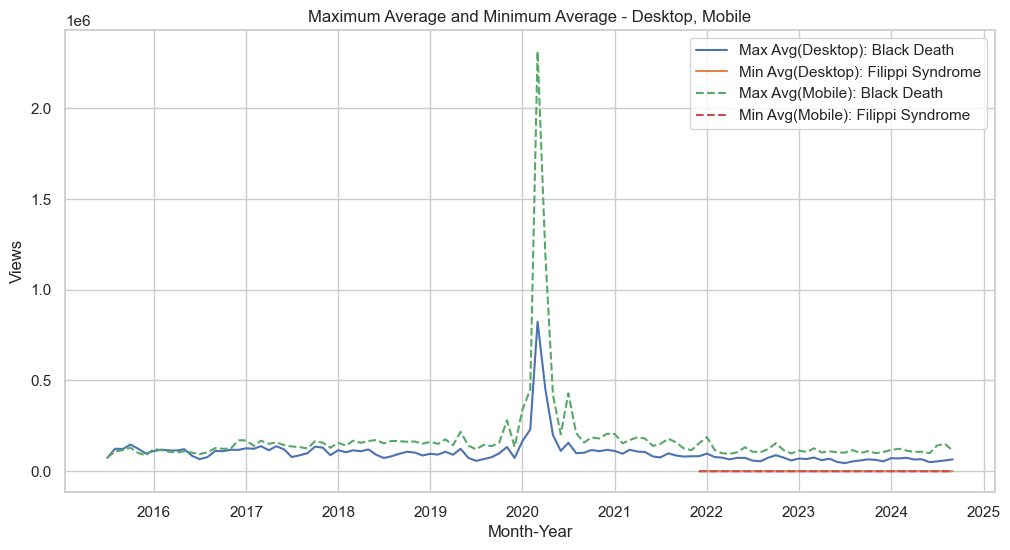

In [44]:
# Set the style of the plots
sns.set(style="whitegrid")

# Set plot size
plt.figure(figsize=(12,6))

# Plot using seaborn lineplot for each case
sns.lineplot(x="date", y="views", data=article_max_d_df, label="Max Avg(Desktop): " + article_max_d["article_title"])
sns.lineplot(x="date", y="views", data=article_min_d_df, label="Min Avg(Desktop): " + article_min_d["article_title"])
sns.lineplot(x="date", y="views", data=article_max_m_df, label="Max Avg(Mobile): " + article_max_m["article_title"], linestyle="dashed")
sns.lineplot(x="date", y="views", data=article_min_m_df, label="Min Avg(Mobile): " + article_min_m["article_title"], linestyle="dashed")

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Maximum Average and Minimum Average - Desktop, Mobile')

# Add legend
plt.legend()

# Save plot as png
plt.savefig("generated_seaborn_plots/max_avg_min_avg.png", bbox_inches='tight')

# Show the plot
plt.show()

### Analysis: Maximum Average, and Minimum Average Page Requests

The time series line graph depicts view trends for "Black Death" and "Filippi Syndrome" on both desktop and mobile platforms from July 2015 to 2024. We see a noticable sharp spike in views for "Black Death" in 2020, where mobile views, reaching over 2 million, exceeded desktop views. After 2020, views for "Black Death" reverted to pre-spike levels, showing a steady and low count. In contrast, "Filippi Syndrome" experienced consistently minimal views across both platforms. Overall, the graph illustrates a temporary surge in "Black Death" interest against a backdrop of stable, low viewership for both subjects.

This surge likely aligns with heightened public interest in pandemics during the COVID-19 outbreak, as people drew connections to historical events. People seemed to have more interest in the "Black Death" over the "Filippi Syndrome" and other diseases.

### Graph 2: Top 10 Peak Page Views


The graph presents time series data for the top 10 articles with the highest peak page views across the entire time series, categorized by access type. To identify these top 10 articles, we first determine the month in which each article experienced its peak page views, then sort the articles based on these peak values. The resulting graph features 20 lines, showcasing the top 10 articles for both desktop and mobile access.

The function `get_top_peak_articles` retrieves the articles with the highest peak views from the aggregated DataFrame. It sorts the DataFrame by the max_views column in descending order and by article_title in ascending order for tie-breaking, ultimately returning a DataFrame containing the top 10 articles based on maximum monthly views. Additionally, helper functions have been created to find articles with the highest and lowest average views.


In [45]:
def get_top_peak_articles(dataframe):
    """
    Retrieves the top 10 articles with the highest peak views from the aggregated DataFrame.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing aggregated statistics 
                                  for articles, including maximum views.

    Returns:
        pd.DataFrame: A DataFrame containing the top 10 articles with the largest maximum monthly views, 
                      sorted in descending order. Each row represents an article.
    """
    # Sort the DataFrame based on the 'max_views' column in descending order
    # and 'article_title' in ascending order for tie-breaking.
    top_articles = dataframe.sort_values(by=["max_views", "article_title"], ascending=[False, True]).head(10)
    return top_articles

C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

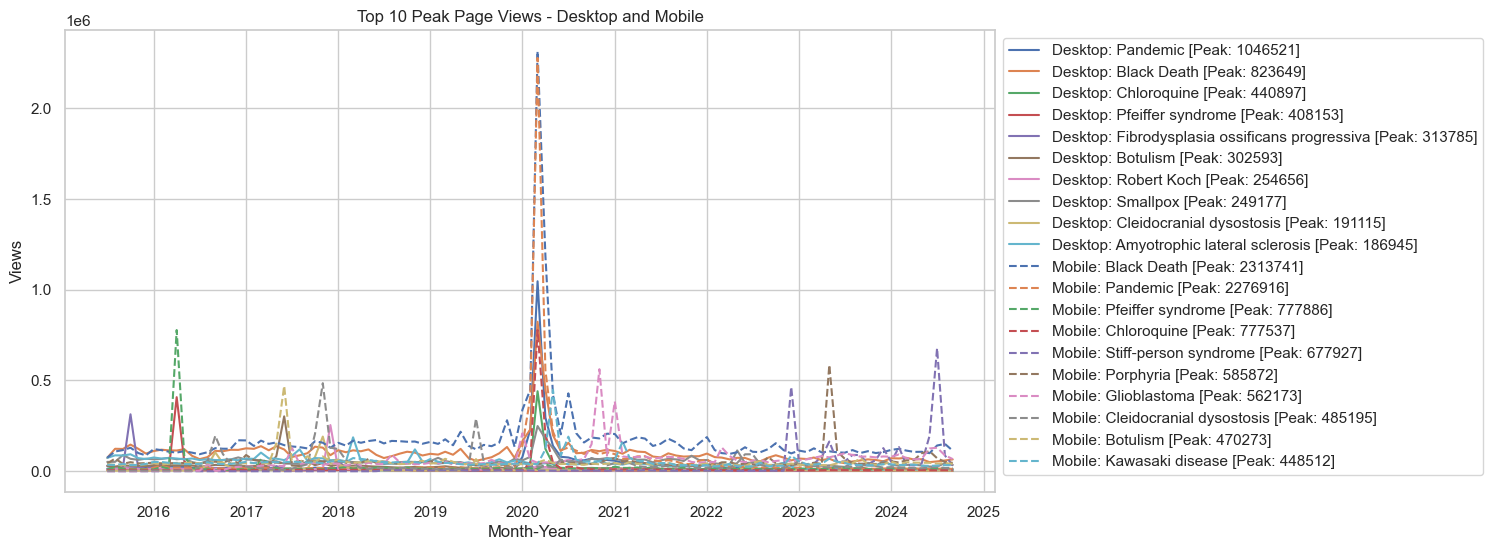

In [51]:
# Set plot parameters
sns.set(style="whitegrid")

# Set plot size
plt.figure(figsize=(12,6))

# Process and plot top 10 peaks for desktop data
top_10_peaks_desktop_df = top_10_peaks(desktop_aggregate_df)
for index, row in top_10_peaks_desktop_df.iterrows():
    # Create temporary dataframe for each peak
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot desktop data
    sns.lineplot(x="date", y="views", data=temp_df, label="Desktop: " + row["article_title"] + " [Peak: " + str(row["max_views"]) + "]")

# Process and plot top 10 peaks for mobile data
top_10_peaks_mobile_df = top_10_peaks(mobile_aggregate_df)
for index, row in top_10_peaks_mobile_df.iterrows():
    # Create temporary dataframe for each peak
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot mobile data with dashed lines
    sns.lineplot(x="date", y="views", data=temp_df, label="Mobile: " + row["article_title"] + " [Peak: " + str(row["max_views"]) + "]", linestyle='--')

# Set the X-axis and Y axis labels, along with the title of the plot
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Top 10 Peak Page Views - Desktop and Mobile')

# Add legend to distinguish between different lines
plt.legend(bbox_to_anchor=(1, 1))

# Save plot as png
plt.savefig("generated_seaborn_plots/top_10_peak_page_views.png", bbox_inches='tight')

# Show the plot
plt.show()

### Analysis: Top 10 Peak Page Views

The time series line graph compares the peak page views for the top 10 topics across desktop and mobile platforms from 2015 to 2024. As in the previous analysis, the most striking observation is the major spike around 2020, with "Pandemic" (both desktop and mobile) leading the surge, reaching over 2 million views on mobile and around 1 million on desktop. This reflects heightened interest in pandemic-related content during the COVID-19 crisis. Furthermore, the evident peaks on the mobile platform relates to the fact that most users have easy access to their phones rather than desktops. Other related topics like "Black Death" and "Chloroquine" also saw substantial spikes, particularly on mobile, highlighting the increased search activity for information on pandemics and potential treatments. Beyond 2020, views and interest for these topics fell sharply and stabilized at lower levels.

Smaller, isolated peaks are observed for topics like "Pfeiffer syndrome" and "stiff person syndrome" but their overall view counts remain significantly lower compared to pandemic-related content. Overall, we can notice a strong correlation between public health crises and search behavior, with pandemic-related topics dominating viewership trends.

### Graph 3: Fewest Months of Data 
This graph shows pages that have the fewest months of available data. It shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

A helper function is created to find the articles with max average views and min average views.

In [47]:
def least_data_months(dataframe):
    """
    Retrieves 10 articles with the least number of months of data from the aggregated DataFrame.

    Args:
        dataframe (pd.DataFrame): A DataFrame containing aggregated statistics 
                                  for articles, including the count of data entries.

    Returns:
        pd.DataFrame: A DataFrame containing 10 rows with the fewest months of data, 
                      where each row represents an article.
    """
    # Sort the DataFrame based on the 'count' column in ascending order 
    # and 'article_title' for tie-breaking, then select the top 10 articles.
    least_data_articles = dataframe.sort_values(by=["count", "article_title"]).head(10)
    return least_data_articles

C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\navya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

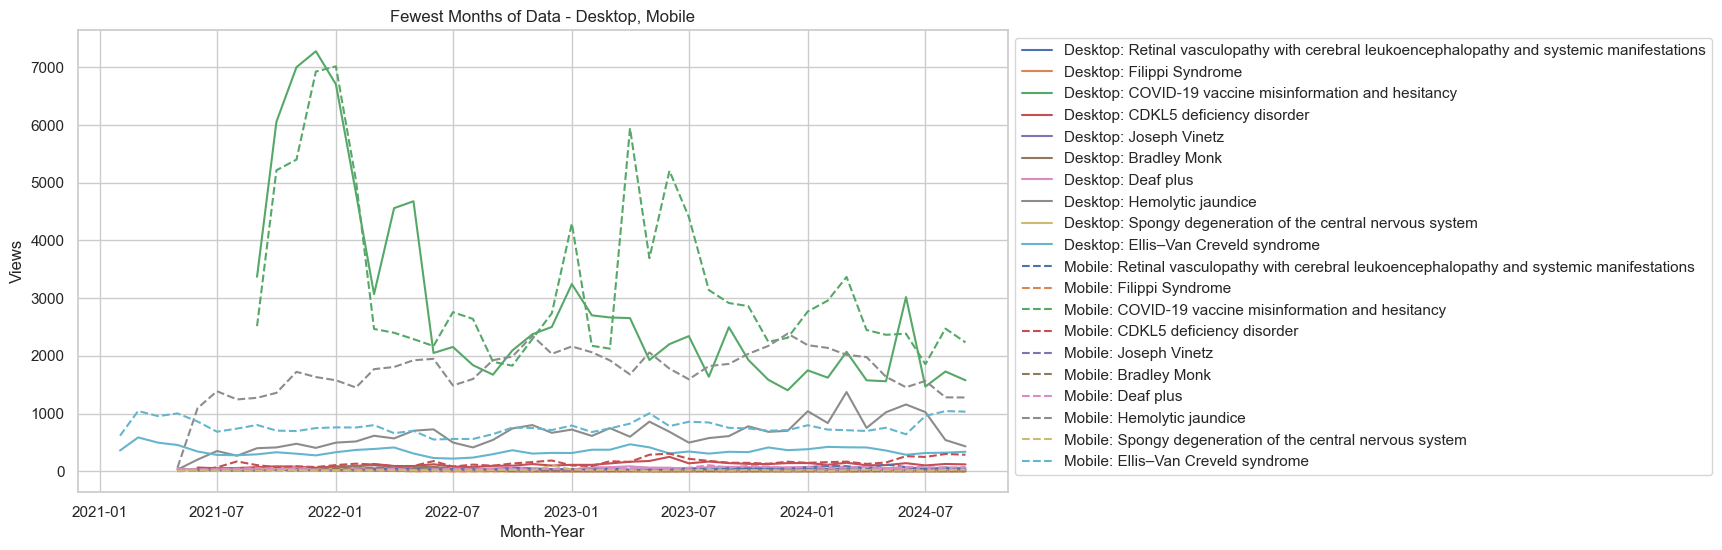

In [48]:
# Set plot paramters
sns.set(style="whitegrid")

# Set plot size
plt.figure(figsize=(12,6))

# Process and plot 10 articles with fewest data for desktop data
fewest_months_desktop_df = fewest_months(desktop_aggregate_df)
for index, row in fewest_months_desktop_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot desktop data
    sns.lineplot(x="date", y="views", data=temp_df, label="Desktop: " + row["article_title"])

# Process and plot 10 articles with fewest data for mobile data
fewest_months_mobile_df = fewest_months(mobile_aggregate_df)
for index, row in fewest_months_mobile_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot mobile data with dashed lines
    sns.lineplot(x="date", y="views", data=temp_df, label="Mobile: " + row["article_title"], linestyle='--')

# Set the X-axis and Y axis labels, along with the title of the plot
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Fewest Months of Data - Desktop, Mobile')

# Add legend to distinguish between different lines
plt.legend(bbox_to_anchor=(1, 1))

# Save plot as png
plt.savefig("generated_seaborn_plots/fewest_months_of_data.png", bbox_inches='tight')

# Display the plot
plt.show()

### Analysis: Fewest Months of Data


The graph shows that articles with fewer months of data have generally low view counts, with exceptions like "COVID-19 vaccine misinformation and hesitancy" and "Hemolytic jaundice," where we see occasional peaks. However, even these views are small compared to previous graphs with millions of views. Notably, there is a distinct difference in access patterns for the "vaccine misinformation" article between desktop and mobile, especially in early 2023, suggesting platform-specific behavior. Understanding this difference may require domain expertise in public health communication or misinformation. Overall, most other topics attract minimal interest, reflecting their niche audience.
